In [1]:
# Commenting out the line below because we are implementing custom version of these classes for more control
# from DeepTextSearch import LoadData,TextEmbedder,TextSearch
import os
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import pandas as pd
from langchain.chat_models import ChatOllama
from langchain.schema import HumanMessage, SystemMessage
import re
from sentence_transformers import SentenceTransformer, util
import numpy as np
import pickle

In [2]:
# Define the dataset constants 
DATASETS_DIR = '../datasets'
DATASET_FILE_NAME = 'Articles.csv'

In [3]:
# Define the model constants
EMBEDDINGS_MODEL = 'sentence-transformers/nli-mpnet-base-v2'
EMBEDDING_DATA_DIR = 'embeddings'
CORPUS_LIST_DATA_FILE = 'corpus_list_data.pickle'
CORPUS_EMBEDDINGS_DATA_FILE = 'corpus_embeddings_data.pickle'


class LoadData:
    def __init__(self):
        self.corpus_list = None

    def from_csv(self, file_path: str):
        csv_data = pd.read_csv(file_path)
        column_name = str(input('Input the text Column Name Please ? : '))
        self.corpus_list = csv_data[column_name].dropna().to_list()
        return self.corpus_list


class TextEmbedder:
    def __init__(self):
        self.corpus_embeddings_data = os.path.join(
            EMBEDDING_DATA_DIR, CORPUS_EMBEDDINGS_DATA_FILE)
        self.corpus_list_data = os.path.join(
            EMBEDDING_DATA_DIR, CORPUS_LIST_DATA_FILE)
        self.corpus_list = None
        self.embedder = SentenceTransformer(EMBEDDINGS_MODEL)
        self.corpus_embeddings = None
        if EMBEDDING_DATA_DIR not in os.listdir():
            os.makedirs(EMBEDDING_DATA_DIR)

    def embed(self, corpus_list: list):
        self.corpus_list = corpus_list
        if len(os.listdir(EMBEDDING_DATA_DIR)) == 0:
            self.corpus_embeddings = self.embedder.encode(
                self.corpus_list, convert_to_tensor=True, show_progress_bar=True)
            pickle.dump(self.corpus_embeddings, open(
                self.corpus_embeddings_data, "wb"))
            pickle.dump(self.corpus_list, open(self.corpus_list_data, "wb"))
            print("Embedding data Saved Successfully!")
            print(os.listdir(EMBEDDING_DATA_DIR))
        else:
            print(
                "Embedding data already present, Do you want Embed & Save Again? Enter yes or no")
            flag = str(input())
            if flag.lower() == 'yes':
                self.corpus_embeddings = self.embedder.encode(
                    self.corpus_list, convert_to_tensor=True, show_progress_bar=True)
                pickle.dump(self.corpus_embeddings, open(
                    self.corpus_embeddings_data, "wb"))
                pickle.dump(self.corpus_list, open(
                    self.corpus_list_data, "wb"))
                print("Embedding data Saved Successfully Again!")
                print(os.listdir(EMBEDDING_DATA_DIR))
            else:
                print("Embedding data already Present, Please Apply Search!")
                print(os.listdir(EMBEDDING_DATA_DIR))

    def load_embedding(self):
        if len(os.listdir(EMBEDDING_DATA_DIR)) == 0:
            print("Embedding data Not present, Please Run Embedding First")
        else:
            print("Embedding data Loaded Successfully!")
            print(os.listdir(EMBEDDING_DATA_DIR))
            return pickle.load(open(self.corpus_embeddings_data, "rb"))


class TextSearch:
    def __init__(self):
        self.corpus_embeddings = pickle.load(
            open(os.path.join(EMBEDDING_DATA_DIR, CORPUS_EMBEDDINGS_DATA_FILE), "rb"))
        self.data = pickle.load(
            open(os.path.join(EMBEDDING_DATA_DIR, CORPUS_LIST_DATA_FILE), "rb"))

    def find_similar(self, query_text: str, top_n=10):
        self.top_n = top_n
        self.query_text = query_text
        self.query_embedding = TextEmbedder().embedder.encode(
            self.query_text, convert_to_tensor=True)
        self.cos_scores = util.pytorch_cos_sim(
            self.query_embedding, self.corpus_embeddings)[0].cpu().data.numpy()
        self.sort_list = np.argsort(-self.cos_scores)
        self.all_data = []
        for idx in self.sort_list[1:self.top_n+1]:
            data_out = {}
            data_out['index'] = int(idx)
            data_out['text'] = self.data[idx]
            data_out['score'] = self.cos_scores[idx]
            self.all_data.append(data_out)
        return self.all_data

In [4]:
# Load the data
if os.path.isfile(os.path.join(DATASETS_DIR, DATASET_FILE_NAME)):
    df = pd.read_csv(os.path.join(DATASETS_DIR, DATASET_FILE_NAME), encoding='latin1')

df.head()

,Article,Date,Heading,NewsType
0,KARACHI: The Sindh government has decided to b...,1/1/2015,sindh govt decides to cut public transport far...,business
1,HONG KONG: Asian markets started 2015 on an up...,1/2/2015,asia stocks up in new year trad,business
2,HONG KONG: Hong Kong shares opened 0.66 perce...,1/5/2015,hong kong stocks open 0.66 percent lower,business
3,HONG KONG: Asian markets tumbled Tuesday follo...,1/6/2015,asian stocks sink euro near nine year,business
4,NEW YORK: US oil prices Monday slipped below $...,1/6/2015,us oil prices slip below 50 a barr,business


In [5]:
# Data pre-processing
data = df['Article'].tolist()
data = [re.split(": *", text, 1)[1] for text in data if ":" in text]
data[:5]

['The Sindh government has decided to bring down public transport fares by 7 per cent due to massive reduction in petroleum product prices by the federal government, Geo News reported.Sources said reduction in fares will be applicable on public transport, rickshaw, taxi and other means of traveling.Meanwhile, Karachi Transport Ittehad (KTI) has refused to abide by the government decision.KTI President Irshad Bukhari said the commuters are charged the lowest fares in Karachi as compare to other parts of the country, adding that 80pc vehicles run on Compressed Natural Gas (CNG). Bukhari said Karachi transporters will cut fares when decrease in CNG prices will be made.                        \r\n\r\n\r\n\r\n\r\n\r\n\r\n\r\n\r\n\r\n\r\n',
 'Asian markets started 2015 on an upswing in limited trading on Friday, with mainland Chinese stocks surging in Hong Kong on speculation Beijing may ease monetary policy to boost slowing growth.Hong Kong rose 1.07 percent, closing 252.78 points higher at

In [6]:
# To use Serching, we must first embed data. After that, we must save all of the data on the local path.
TextEmbedder().embed(corpus_list=data)

Batches:   0%|          | 0/79 [00:00<?, ?it/s]

Embedding data Saved Successfully!
['corpus_embeddings_data.pickle', 'corpus_list_data.pickle']


In [7]:
# Loading Embedding data
corpus_embedding = TextEmbedder().load_embedding()

Embedding data Loaded Successfully!
['corpus_embeddings_data.pickle', 'corpus_list_data.pickle']


In [18]:
# You must include the query text and the quantity of comparable texts you want to search for.
TextSearch().find_similar(query_text="Something cool",top_n=5)

[{'index': 1327,
  'text': 'The giant search engine Google has dedicated its doodle to mark the start of the ICC T20 Cricket World Cup 2016.</strongThe extravaganza will kick start from Tuesday and end on April 3. The event will be held across seven venues in India with 16 teams taking part in it.The doodle shows an amazing bird\x92s eye view of a jam packed cricket stadium while the two teams are playing the match and audience are cheering them.The crowd can be seen supporting both the teams.A huge Google banner can also be witnessed in the background.A click on the doodle directs the users to a new page consisting of the entire schedule of the upcoming matches.In the first match Zimbabwe will take on Hong Kong in Nagpur while in the second match Scotland will face Afghanistan at the same venue.The epic encounter of the event will be held between traditional rivals India and Pakistan on March 19 at Dharamshala.',
  'score': 0.23426075},
 {'index': 1589,
  'text': 'Paul Hawkins, the in

# Cluster the vector embeddings

In [9]:
# Move embeddings to cpu
corpus_embedding_cpu = corpus_embedding.cpu()

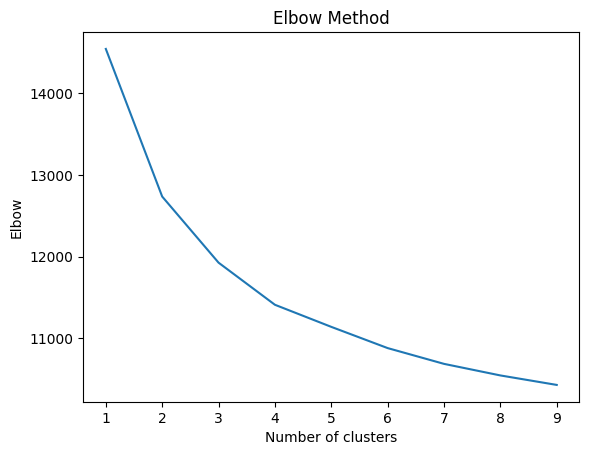

In [10]:
# Find the optimal number of clusters using the elbow method
elbow = []
for i in range(1, 10):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(corpus_embedding_cpu)
    elbow.append(kmeans.inertia_)

# Plot the elbow method
plt.plot(range(1, 10), elbow)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Elbow')
plt.show()

In [11]:
NUMBER_OF_CLUSTERS = 5
kmeans = KMeans(n_clusters=NUMBER_OF_CLUSTERS, init='k-means++', max_iter=300, n_init=10, random_state=0)
kmeans.fit(corpus_embedding_cpu)
df_clusters = pd.DataFrame(data)
df_clusters['cluster'] = kmeans.labels_

In [12]:
# Get first 5 elements of each cluster
for i in range(NUMBER_OF_CLUSTERS):
    print(f'Cluster {i}')
    print(df_clusters[df_clusters['cluster'] == i].head(5))
    print('\n')

Cluster 0
                                                   0  cluster
1  Asian markets started 2015 on an upswing in li...        0
2  Hong Kong shares opened 0.66 percent lower Mon...        0
3  Asian markets tumbled Tuesday following painfu...        0
4  US oil prices Monday slipped below $50 a barre...        0
5  Oil prices tumbled Tuesday to fresh 5.5-year l...        0


Cluster 1
                                                      0  cluster
44    Cricket fever has gripped Australia with the W...        1
930   Reflecting upon Pakistans history, we come ac...        1
995   Left arm fast bowler Mohammad Amir, who was ba...        1
998   New Zealand captain Brendon McCullum on Sunday...        1
1004  Pakistans fast bowler Mohamamd Amir, who has ...        1


Cluster 2
                                                     0  cluster
310  Air France's human resources manager had his s...        2
378  Symmetry Digital and Iris Digital, full servic...        2
588  Johnson

In [13]:
chat = ChatOllama(
    # llama2:13b, llama2:7b, mistral:7b, dolphin-mistral:7b
    model="mistral:7b",
    temperature=0.8,
)

In [14]:
def get_best_topic(texts, tries=0):
    def prompt(texts):
        return f"""
    You have given list of texts.
    Your task is to find the best matching topic for them.
    Answer with only one topic which best describes the given.
    Don't use any other information, clarifications or additions.
    Answer in this format:
    Topic: topic

    texts: {texts}
    """

    answer = chat(
        [
            SystemMessage(content=prompt(texts)),
            HumanMessage(content="What is the best topic for these texts?"),
        ]
    ).content

    match = re.search(r'Topic: (.*)', answer)
    if match:
        return match.group(1)
    elif tries < 3:
        return get_best_topic(texts, tries + 1)
    else:
        return "Other"

In [19]:
texts = df_clusters[df_clusters['cluster'] == 0][:10]
get_best_topic(texts)

'Financial Markets (specifically Asian and Oil markets)'

In [16]:
for i in range(NUMBER_OF_CLUSTERS):
    texts = df_clusters[df_clusters['cluster'] == i][:10]
    print(f'Cluster {i}')
    print(get_best_topic(texts))
    print('\n')

Cluster 0
Financial Markets (specifically Asian markets and oil prices)


Cluster 1
Cricket / Pakistani Cricket


Cluster 2
News and Current Events


Cluster 3
Cricket


Cluster 4
Current Events in Pakistan




In [17]:
# TODO: find or train / fine-tune more optimized model for topic classification and use it to classify the clusters
# TODO: explore more advanced clustering techniques like HDBSCAN, OPTICS, DBSCAN, etc. (preferably with auto-detection of the number of clusters)